In [29]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows=10)
player_data<-read_csv("https://raw.githubusercontent.com/AndrewH-dsci/DSCI-Group-Project/refs/heads/main/players.csv?token=GHSAT0AAAAAADBWKEMCNQWO3KBYHHO5MP7IZ7QPFDA")


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


<h1> Exploratory Visualizations and Summary Statistics </h1>

In [30]:
gender_counts<-player_data|>
    group_by(gender)|>
    summarize(count=n())|>
    arrange(desc(count))
gender_counts
experience_counts<-player_data|>
    group_by(experience)|>
    summarize(count=n())
experience_counts

gender,count
<chr>,<int>
Male,124
Female,37
Non-binary,15
Prefer not to say,11
Two-Spirited,6
Agender,2
Other,1


experience,count
<chr>,<int>
Amateur,63
Beginner,35
Pro,14
Regular,36
Veteran,48


<h1>Data Wrangling</h1>

In [22]:
wrangled_data<-player_data|>
    mutate(experience=as.factor(experience), gender=as.factor(gender))|>
    mutate(experience_numeric=recode(
                        experience, 
                             "Amateur"=1, 
                             "Beginner"=2, 
                             "Regular"=3, 
                             "Pro"=4, 
                             "Veteran"=5
                                     ),
            gender_numeric=recode(
                        gender, 
                             "Male"=1, 
                             "Female"=2, 
                             "Non-binary"=3, 
                             "Prefer not to say"=4, 
                             "Two-Spirited"=5, 
                             "Agender"=6,
                             "Other"=7
                                )
          )|>
    select(experience_numeric, gender_numeric)|>
    bind_cols(player_data)|>
    filter(Age!="NA")|>
    select(experience, experience_numeric, gender, gender_numeric, Age, played_hours)|>
    filter(played_hours<=80)

wrangled_data

experience,experience_numeric,gender,gender_numeric,Age,played_hours
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
Pro,4,Male,1,9,30.3
Veteran,5,Male,1,17,3.8
Veteran,5,Male,1,17,0.0
Amateur,1,Female,2,21,0.7
Regular,3,Male,1,21,0.1
Amateur,1,Female,2,17,0.0
Regular,3,Female,2,19,0.0
Amateur,1,Male,1,21,0.0
Amateur,1,Male,1,17,0.1


<h1> Predictive Modeling </h1>

In [23]:
set.seed(1234)

initial_split<-initial_split(wrangled_data, prop=0.8, strata=played_hours)
player_training<-training(initial_split)
player_testing<-testing(initial_split)

kvals<-tibble(neighbors=seq(from=1, to=100, by=1))

player_vfold<-vfold_cv(player_training, v=5, strata=played_hours)

In [24]:
player_recipe<-recipe(played_hours~experience_numeric+Age, data=player_training)|>
    step_scale(all_predictors())|>
    step_center(all_predictors())

player_spec<-nearest_neighbor(weight_func="rectangular", neighbors=tune())|>
    set_engine("kknn")|>
    set_mode("regression")

player_tune<-workflow()|>
    add_recipe(player_recipe)|>
    add_model(player_spec)|>
    tune_grid(resamples=player_vfold, grid=kvals)|>
    collect_metrics()|>
    filter(.metric=="rmse")|>
    select(neighbors, mean)

In [27]:
lowest_rmse_k<-slice_min(player_tune, mean)
lowest_rmse_k

neighbors,mean
<dbl>,<dbl>
80,6.107613


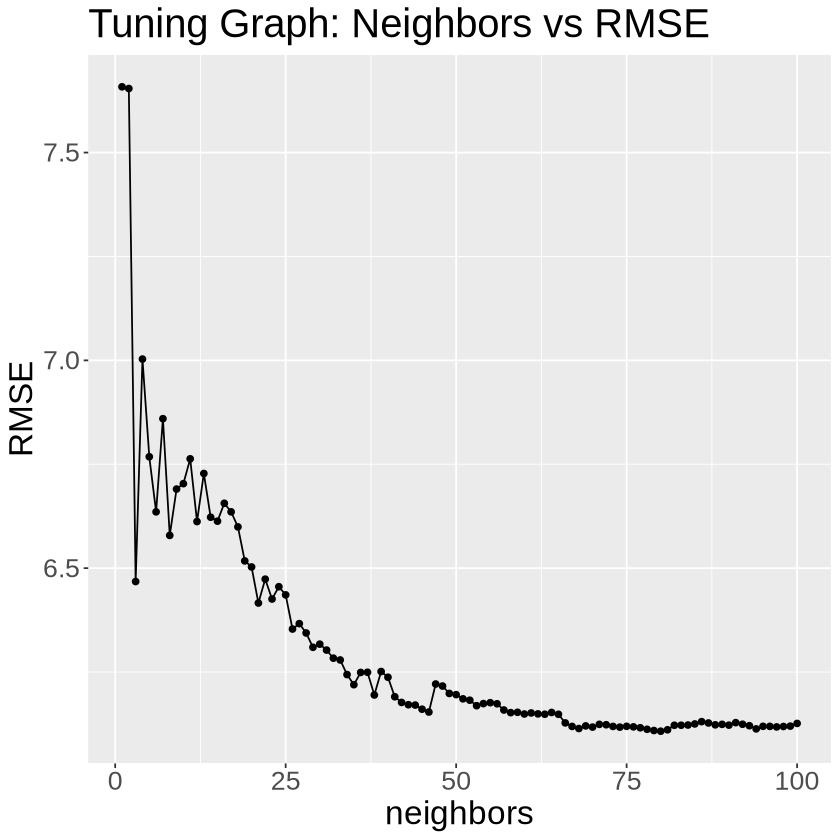

In [28]:
tune_graph<-player_tune|>
    ggplot(aes(x=neighbors, y=mean))+
        geom_point()+
        geom_line()+
        labs(x="neighbors", y="RMSE", title="Tuning Graph: Neighbors vs RMSE")+
        theme(text=element_text(size=20))
tune_graph

In [20]:
player_spec_tuned<-nearest_neighbor(weight_func="rectangular", neighbors=80)|>
    set_engine("kknn")|>
    set_mode("regression")

player_fit<-workflow()|>
    add_recipe(player_recipe)|>
    add_model(player_spec_tuned)|>
    fit(data=player_training)

player_predictions<-player_fit|>
    predict(player_testing)|>
    bind_cols(player_testing)|>
    metrics(truth=played_hours, estimate=.pred)|>
    filter(.metric=="rmse")
player_predictions

The code below is a control group of always predicting zero to compare the two RMSPE's.

In [10]:
always_predict_zero_rmspe<-tibble(prediction=rep(0, times=39))|>
    bind_cols(player_testing)|>
    metrics(truth=played_hours, estimate=prediction)|>
    filter(.metric=="rmse")
always_predict_zero_rmspe

Warning message:
“A correlation computation is required, but `estimate` is constant and has 0
standard deviation, resulting in a divide by 0 error. `NA` will be returned.”


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,10.18762
